In [1]:
# Seed value
# Apparently you may use different seed values at each stage
seed_value= 100

# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
import os
os.environ['PYTHONHASHSEED']=str(seed_value)

# 2. Set `python` built-in pseudo-random generator at a fixed value
import random
random.seed(seed_value)

# 3. Set `numpy` pseudo-random generator at a fixed value
import numpy as np
np.random.seed(seed_value)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
import tensorflow as tf
tf.random.set_seed(seed_value)
# for later versions:
# tf.compat.v1.set_random_seed(seed_value)

# 5. Configure a new global `tensorflow` session
from keras import backend as K
# session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
# sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
# K.set_session(sess)
# for later versions:
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)
import keras

2021-12-12 19:07:23.757863: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.patheffects as PathEffects
import matplotlib.image as mpimg
from sklearn.model_selection import KFold #--needed for cross validation
from sklearn.preprocessing import StandardScaler
from scipy import signal
# from keras.callbacks import History
from keras.models import Sequential
from keras.layers import Conv1D, Dense, Flatten, Dropout
from keras.activations import relu
from keras.layers.pooling import MaxPooling1D,GlobalMaxPool1D
from tensorflow.keras.optimizers import  Adam
from keras.initializers import TruncatedNormal,glorot_normal
from autokeras import StructuredDataRegressor
import keras_tuner as kt
import scipy as sc
from scipy import signal
import pickle
pickle.HIGHEST_PROTOCOL = 4
import pandas as pd
from sklearn.metrics import mean_squared_error as MSE

In [3]:
plot_fwi = False
plot_raycoverage = False
plot_network = False
# ModelSetName = 'SuperStack'
ModelSetName = 'HourStack'

In [4]:
#import pickle

class GeoData:
    def __init__(self,file):
        self.Scaler = StandardScaler()
        self.df = pd.read_hdf(file)
        #self.df = pd.read_pickle("./SuperStack.pkl")
        print(self.df.columns)
        X_df= self.df[["SRC_Lat","SRC_Lon","REC_Lat","REC_Lon"]].copy()
        y_df= self.df[["Greens"]].copy()

        self.X=  X_df.to_numpy()
        self.y= y_df.to_numpy()
        self.y=  self.y[:,0]
        self.y = [ x.tolist() for x in self.y]
        self.y= np.array(self.y)
        self.y= self.y/ np.max(self.y,axis=1).reshape(-1,1)

        #self.y.shape = (380)
        print(self.y.shape)
        #print(self.y)
        print(self.X.shape)
        print(self.X[0])
        print(self.y[0])
testFile= './Data/Supersets/hdf/' + ModelSetName + '.hdf'
Geo = GeoData(testFile)

Index(['SRC_ID', 'REC_ID', 'SRC_Lat', 'SRC_Lon', 'REC_Lat', 'REC_Lon',
       'Greens'],
      dtype='object')
(8284, 3001)
(8284, 4)
[  41.467999 -105.722099   41.467602 -104.824799]
[ 0.03820507  0.03856462  0.03912802 ... -0.14665908 -0.17726582
 -0.2081426 ]


In [5]:
model_file = './Models/' + ModelSetName + '.tf'
model = tf.keras.models.load_model(model_file)

2021-12-12 19:07:27.753101: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


In [6]:
print(np.unique(model.predict(Geo.X[10:10+1]) - model.predict(Geo.X[50:50+1])))
assert len(np.unique(model.predict(Geo.X[10:10+1]) - model.predict(Geo.X[50:50+1])))>10

[-0.03365857 -0.03306815 -0.03300011 ...  0.03275676  0.03351348
  0.03375048]


In [7]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 4)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 4)                 0         
_________________________________________________________________
normalization (Normalization (None, 4)                 9         
_________________________________________________________________
dense (Dense)                (None, 32)                160       
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 16)                0     

In [9]:
model.optimizer

In [8]:
from keras.utils.vis_utils import plot_model

if plot_network:
    plot_model(model, show_shapes=True, show_layer_names=True,to_file='./Figures/Network_Architecture_' +  ModelSetName + '.png')
# from keras_visualizer import visualizer
# visualizer(model, format='png', view=True)
# plt.savefig('./Figures/Network_Architecture_' +  ModelSetName + '.png')

In [9]:
low = 1
high = 60
fs = 50

def quickFilter(sig,lowStop,highStop,fs=50):
    sig = signal.detrend(sig)
    sig = sig - np.mean(sig)
    nyq = 0.5*fs
    wn = [lowStop/nyq,highStop/nyq]
    order = 8
    sos = signal.butter(order,wn,btype="bandpass",fs=fs, output= "sos")
    filteredOutput= signal.detrend(signal.sosfiltfilt(sos,sig))
    filteredOutput = filteredOutput - np.mean(filteredOutput)
    return filteredOutput

def SSR(y_predict, y_truth):
    assert y_predict.shape[0]==  y_truth.shape[0], "In SSR: give invalid length compared to the length of true outputs"
    result=0
    yDiff = [(y_truth[i] - y_predict[i])**2 for i in range(len(y_truth))]
    result = np.sum(yDiff)
    return result
#SSR(outPut,yTruth)

def singleCompare(model_singleCompare,indexNum,X,y, filterVal= False,plt_on=True): #assumed model is trained
    output = model_singleCompare.predict(X[indexNum:indexNum+1]).flatten()
    yTruth = y[indexNum:indexNum+1].flatten()
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    if filterVal:
        output= quickFilter(output,low,high,fs)
        yTruth = quickFilter(yTruth,low,high,fs)
    # yTruth = yTruth/np.max(yTruth)
    # output = output/np.max(output) #---------------------------------norming here
    # op_residual_mn = np.mean([yTruth,output],axis=0)
    # output = op_residual_mn
    ssr= SSR(output,yTruth)
    mse= MSE(yTruth,output)
    if plt_on:
        plt.figure(figsize=(9,10))
        bgc = 0.8
        t= np.arange(0,3001)/fs
        plt.subplot(2,1,1)
        plt.plot(t, output, alpha=.8,color="b",linewidth=4)
        plt.title('Predicted Greens Function\n' + 'MSE: ' + str((np.round(mse*1000)/1000)) + ' SSE: ' + str(np.round(ssr*1000)/1000),fontweight='bold',fontsize=15)
        plt.xlim(np.min(t),np.max(t))
        plt.grid(visible=True,alpha=1)
        plt.xticks(fontweight='bold',fontsize=13)
        plt.yticks(fontweight='bold',fontsize=13)
        ax = plt.gca()
        ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
        plt.subplot(2,1,2)
        plt.plot(t, yTruth,alpha=.8,color="r",linewidth=4)
        plt.title("Observed Greens Function",fontweight='bold',fontsize=15)
        plt.xlim(np.min(t),np.max(t))
        plt.grid(visible=True,alpha=1)
        plt.xticks(fontweight='bold',fontsize=13)
        plt.yticks(fontweight='bold',fontsize=13)
        ax = plt.gca()
        ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
        print("SSR for Single Sample: ", ssr)
        print("MSE for Single Sample: ", mse)
    return mse

def pred_greens(model,xq,xx):
    xq = map_to_nearest(xq,xx) #<-----comment this out after testing
    G = model.predict(xq)
    if np.shape(xq)[0]==1:
        G = G.flatten()
    G = G - np.mean(G)
    G = G - G[0]
    return G

def map_to_nearest(src_rec,xx):
    s_map = []
    r_map = []
    xm = np.unique(xx[:,0:2],axis=0)
    for i in range(src_rec.shape[0]):
        s_map.append(np.argmin(np.sum((src_rec[i,0:2].reshape(-1,1).T - xm)**2,axis=1)))
        r_map.append(np.argmin(np.sum((src_rec[i,2:5].reshape(-1,1).T - xm)**2,axis=1)))
    return np.hstack((xm[s_map,:],xm[r_map,:]))

def get_stf(length=3001,stf_amp=1e-15):
    stf = sc.signal.unit_impulse(length)
    stf = -1*quickFilter(stf,low,high,fs)
    stf = stf*(np.linspace(1,0,len(stf))**2)
    stf = (stf/np.max(stf))*stf_amp
    stf = stf - stf[0]
    return stf

def green_to_seis(G,stf_amp=1e-5,flt=True):
    # G = signal.detrend(G)
    # G = G - np.mean(G)
    stf = get_stf(length=G.shape[1],stf_amp=stf_amp)
    stf = G*0 + stf
    # G = quickFilter(G,1,80, fs)
    seis = sc.signal.convolve(G,stf)
    seis = seis[:,0:G.shape[1]]
    if flt:
        seis = quickFilter(seis,1,80, fs)
    seis = seis - np.mean(seis,axis=1).reshape(-1,1)
    seis = seis - seis[0]
    return G,stf,seis

def gaussian_noise(seis):
    for i in range(seis.shape[0]):
        seis[i,:] = seis[i,:] + np.random.normal(loc=10*np.mean(seis[i,:]),scale=3*np.std(seis[i,:]))
    return seis

def plot_G_STF_Seis(G,stf,seis):
    bgc = 0.8
    lw = 4
    alpha = 1
    t = np.linspace(1,len(G),len(G))/fs
    plt.figure(figsize=(26,9))
    plt.subplot(1,3,1)
    plt.plot(t,G,linewidth=lw,c='G')
    plt.grid(alpha=alpha,visible=True)
    plt.title('(G) Greens Function',fontweight='bold',fontsize=18)
    ax = plt.gca()
    ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
    plt.xticks(fontweight='bold',fontsize=13)
    plt.yticks(fontweight='bold',fontsize=13)
    plt.ylabel('Response Acceleration \n ~ dV/dt',fontweight='bold',fontsize=15)
    plt.subplot(1,3,2)
    plt.plot(t,stf,linewidth=lw,c='r')
    plt.grid(alpha=alpha,visible=True)
    plt.title('U(t) = G(t) * S(t) + Noise(t) \n (S) Source Function',fontweight='bold',fontsize=18)
    plt.xlabel('Time (t) - Seconds',fontweight='bold',fontsize=15)
    plt.ylabel('Source Displacement \n (Meters)',fontweight='bold',fontsize=15)
    ax = plt.gca()
    ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
    plt.xticks(fontweight='bold',fontsize=13)
    plt.yticks(fontweight='bold',fontsize=13)
    plt.subplot(1,3,3)
    plt.title('(U) Seismic Trace Function',fontweight='bold',fontsize=18)
    plt.ylabel('Observed Velocity \n (Meters / Second)',fontweight='bold',fontsize=15)
    plt.plot(t,seis,linewidth=lw,c='b')
    plt.grid(alpha=alpha,visible=True)
    ax = plt.gca()
    plt.xticks(fontweight='bold',fontsize=13)
    plt.yticks(fontweight='bold',fontsize=13)
    ax.set_facecolor((bgc*1.0, bgc*1.0, bgc*1.0))
    plt.xlim(np.min(t),np.max(t))
    plt.show()

def get_box(xx,Ndeg=360):
    box_min = np.min(xx,axis=0)
    box_min = np.array([np.min([box_min[0],box_min[2]]),np.min([box_min[1],box_min[3]])])
    box_max = np.max(xx,axis=0)
    box_max = np.array([np.max([box_max[0],box_max[2]]),np.max([box_max[1],box_max[3]])])
    # print('- Model Bounds - ')
    # print('Min: ' + str(box_min))
    # print('Max: ' + str(box_max))
    Ndeg = 360
    westwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4)),np.linspace(box_min[1],box_max[1],int(Ndeg/4))*0 + box_min[1]]).T
    eastwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4)),np.linspace(box_min[1],box_max[1],int(Ndeg/4))*0 + box_max[1]]).T
    northwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4))*0+box_max[0],np.linspace(box_min[1],box_max[1],int(Ndeg/4))]).T
    southwall = np.array([np.linspace(box_min[0],box_max[0],int(Ndeg/4))*0+box_min[0],np.linspace(box_min[1],box_max[1],int(Ndeg/4))]).T
    box = np.vstack((eastwall,northwall,westwall,southwall))
    return box

def get_circle(Ndeg=360):
    map_center = [40.14671214, -104.62999107]
    r_max = 1.0
    r_max = 1.9894304947170927
    Lat_circle = (np.sin(np.linspace(0,2*np.pi,Ndeg))*r_max) + map_center[0]
    Lon_circle = (np.cos(np.linspace(0,2*np.pi,Ndeg))*r_max) + map_center[1]
    circle = np.hstack((Lat_circle.reshape(-1,1),Lon_circle.reshape(-1,1)))
    # outbounds = np.array([[  41.466099, -103.1427  ],[  40.894699, -105.944   ],[  41.467999, -105.722099],[  38.904499, -105.833702]])
    # Lon_circle = np.hstack((Lon_circle,outbounds[:,1]))
    # Lat_circle = np.hstack((Lat_circle,outbounds[:,0]))
    # plt.scatter(Lon_circle,Lat_circle,c='b')
    # plt.scatter(np.unique(xx[:,0:2],axis=0)[:,1].flatten(),np.unique(xx[:,0:2],axis=0)[:,0].flatten(),c='r')
    # plt.show()
    return circle

-0.3199383300203729

Index: 71
SSR for Single Sample:  442.8458666892599
MSE for Single Sample:  0.14756610019635452


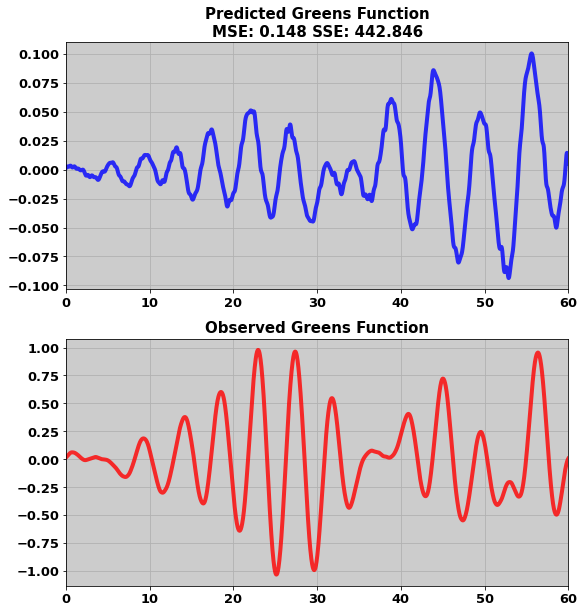

In [10]:
mse = []
flt = True
Ntraces = 380
Nchoose = 71
plt_on = True
for N in range(Ntraces):
    plt_on = False
    if N==Nchoose:
        plt_on = True
    # if N>0:
    #     plt_on = False
    if plt_on:
        print('Index: ' + str(N))
    mse.append(singleCompare(model,N,Geo.X,Geo.y,flt,plt_on=plt_on))
    if plt_on:
        plt.savefig('./Figures/PredTrue_Greens/PredTrue_Greens_' + ModelSetName +  '_' + str(N) + '.png',dpi=300)
        plt.show()
# plt.plot(np.arange(0,len(mse)),mse)
# plt.title('Mean Squred Error (MSE)')
# np.where(np.array(mse)<0.1)

In [11]:
Avg_MSE = np.mean(mse)
print('AVERAGE MSE:::: ' + str(Avg_MSE))

AVERAGE MSE:::: 0.15774549938763427


Station: 0 :: [[  40.014259 -105.270724]]


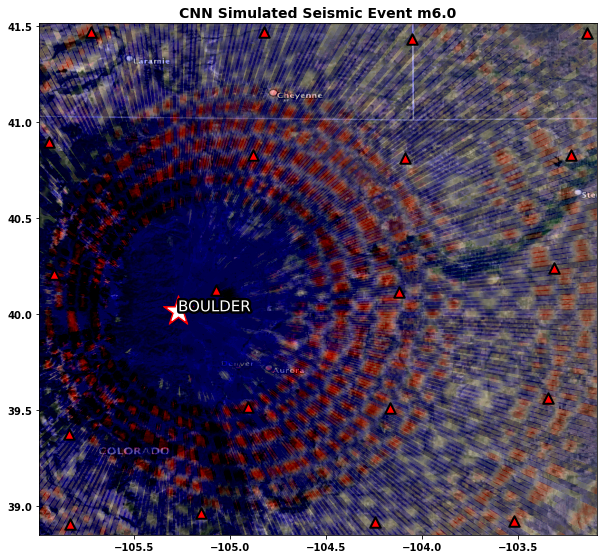

COMPLETE


In [23]:
plot_fwi = True
if plot_fwi:

    filename = 'FWI_Bldr'
    bldr = [40.014259,-105.270724]
    flt = False  #filter option for seismic output
    xq = np.array(bldr).reshape(-1,2)
    mag = 6.0

    # # filename ='FWI_Arbitrary'
    # xq = np.array([[39.5,-104.0],[40.5,-105.5],[41.2,-104.75],[41.3,-105.5]])
    # mag = 4.5

    # ## #- ---20minute plot run...-----
    # filename ='FWI_Known_Station' + str(i)
    # xq = STATIONS
    # mag = 6.5

    Ndeg = 360
    STATIONS = np.unique(Geo.X[:,0:2],axis=0)
    for i in range(xq.shape[0]):
        x_request = xq[i,:].flatten().reshape(-1,2)

        xx = Geo.X
        # i = 500
        # xq = np.mean(xx,axis=0)[0:2].reshape(1,2) + 0.1

        plt.figure(figsize=(10,10))
        src = x_request
        # rec = get_box(xx,Ndeg = Ndeg)
        rec = get_circle(Ndeg = Ndeg)
        src = rec*0 + src
        rec = rec
        src_rec = np.hstack((src,rec))
        G = pred_greens(model,src_rec,xx)
        G,stf,seis = green_to_seis(G,stf_amp=np.log(mag)*1e-5,flt=flt)
        # G = G - np.mean(G,axis=1).reshape(-1,1)
        N = rec.shape[0]
        K = G.shape[1]
        trc = seis
        trc = sc.signal.savgol_filter(trc,7*int(2*(fs/2)+1),8,axis=0)
        trc = gaussian_noise(trc)**2
        img = mpimg.imread('./BoulderArea.png')
        bounds = [-105.994573, -103.088725,38.850346,41.514494]
        plt.imshow(img,extent=[bounds[0], bounds[1],bounds[2], bounds[3]])
        vmin = 0
        vmax = 0
        cmap = 'seismic'
        for ii in range(N-1):
            c_src = src[ii,:]
            c_rec = rec[ii,:]
            lat = np.linspace(c_src[0],c_rec[0],K)
            lon = np.linspace(c_src[1],c_rec[1],K)
            plt.scatter(lon,lat,c=trc[ii,:],cmap=cmap,alpha=0.004)
            vmin = np.min([vmin,np.min(trc[ii,:])])
            vmax = np.min([vmax,np.max(trc[ii,:])])
        # sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
        # plt.colorbar(sm,cax=plt.gca())
        plt.xticks(fontweight='bold')
        plt.yticks(fontweight='bold')
        plt.title('CNN Simulated Seismic Event m' + str(mag) ,fontweight='bold',fontsize=14)
        # plt.text(bldr[1],bldr[0],'BOULDER',fontweight='bold',color='k',fontsize=20)
        txt = plt.text(bldr[1],bldr[0],'BOULDER', size=15, color='w')
        txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
        plt.scatter(x_request[0][1],x_request[0][0],marker='*',c='r',s=1000)
        plt.scatter(x_request[0][1],x_request[0][0],marker='*',c='w',s=500)
        plt.scatter(STATIONS[:,1].tolist(),STATIONS[:,0].tolist(),marker='^',color='r',s=110,zorder=2,edgecolors='k',linewidths=2)
        # ax = plt.gca()
        plt.xlim((bounds[0],bounds[1]))
        plt.ylim((bounds[2],bounds[3]))
        # print(ax.get_xlim())
        # print(ax.get_ylim())
        plt.savefig('./Figures/FWI_Models/' + filename + '_' + str(i) + '.png',dpi=300)
        print('Station: ' + str(i) + ' :: ' + str(x_request))
        plt.show()
    print('COMPLETE')

In [13]:
la,lo = np.meshgrid((np.array((np.max(Geo.X[:,0],axis=0), np.min(Geo.X[:,0],axis=0)))),(np.array((np.max(Geo.X[:,1],axis=0), np.min(Geo.X[:,1],axis=0)))))
bounds = np.hstack((la.reshape(-1,1),lo.reshape(-1,1)))
map_center = [40.14671214, -104.62999107]
r = np.sum((bounds - map_center)**2,axis=1)**0.5
print('--Data Bounds--')
print(bounds)
print('Max radii from data center: ' + str(np.max(r)))

--Data Bounds--
[[  41.467999 -103.1427  ]
 [  38.904499 -103.1427  ]
 [  41.467999 -105.944   ]
 [  38.904499 -105.944   ]]
Max radii from data center: 1.9894304947170927


In [14]:
# plot_raycoverage = True
if plot_raycoverage:
    U,COUNTS = np.unique(Geo.X,axis=0,return_counts=True)
    STATIONS = np.unique(Geo.X[:,0:2],axis=0)
    lw = 3
    bldr = [40.014259,-105.270724]
    bounds = [-105.994573, -103.088725,38.850346,41.514494]

    img = mpimg.imread('./BoulderArea.png')
    plt.figure(figsize=(10,10))
    plt.imshow(img,extent=[bounds[0], bounds[1],bounds[2], bounds[3]])
    plt.xticks(fontweight='bold')
    plt.yticks(fontweight='bold')
    plt.title('Ray Coverage',fontweight='bold',fontsize=14)
    plt.xlim((bounds[0],bounds[1]))
    plt.ylim((bounds[2],bounds[3]))

    vmin = np.min(COUNTS)
    vmax = np.max(COUNTS)
    for i in range(U.shape[0]):
        plt.plot(U[i,[1,3]].tolist(),U[i,[0,2]].tolist(),linewidth=lw,color='k',zorder=1)
    # for i in range(STATIONS.shape[0]):
    #     plt.text(STATIONS[i,1].tolist(),STATIONS[i,0].tolist(),str(i+1),fontweight='bold',color='r',horizontalalignment='center',verticalalignment='center',fontsize=15)
    # plt.plot(get_circle(360)[:,1],get_circle(360)[:,0],c='b')
    plt.scatter(STATIONS[:,1].tolist(),STATIONS[:,0].tolist(),marker='^',color='r',s=200,zorder=2,edgecolors='k',linewidths=2)
    plt.xlim((bounds[0],bounds[1]))
    plt.ylim((bounds[2],bounds[3]))

    # sm = plt.cm.ScalarMappable(cmap=cm.hot, norm=plt.Normalize(vmin=0, vmax=1))
    # ax = plt.gca()
    # plt.colorbar(sm,cax=ax)
    # plt.clim(vmin,vmax)
    txt = plt.text(bldr[1],bldr[0],'BOULDER', size=15, color='w')
    txt.set_path_effects([PathEffects.withStroke(linewidth=5, foreground='k')])
    plt.savefig('./Figures/RayCoverage ' + '.png',dpi=300)
    plt.show()